In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_raw = pd.read_csv('coords_filtered.csv', header=None, sep=";")
df_raw.columns = ["code", "Name", "Latitude", "Longitude", "desc"]

In [5]:
# randomly subsample 1000 indices
df_sampled = df_raw.sample(n=100000, random_state=42)
df = df_sampled.copy()

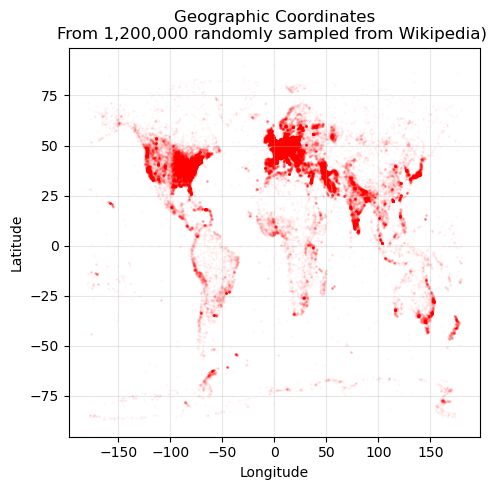

In [ ]:
# Full version with labels and formatting
import pandas as pd
import matplotlib.pyplot as plt


# Create 500x500 pixel plot
plt.figure(figsize=(5, 5), dpi=100)

# Plot points
plt.scatter(df['Longitude'], df['Latitude'], c='red', s=1, alpha=0.025)

# Format plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Geographic Coordinates\nFrom {round(len(df_raw), -5):,} randomly sampled from Wikipedia) ')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save to figure
plt.savefig('coords_sampled.png', dpi=300, bbox_inches='tight')